# Convolutional Neural Network


## Extract dataset

In [ ]:
import zipfile
with zipfile.ZipFile("/content/archive.zip","r") as zip_ref:
    zip_ref.extractall("dataset")

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from distutils.dir_util import copy_tree, remove_tree
import os

#print(os.listdir("/content/dataset/Dataset"))
#print("TensorFlow Version:", tf.__version__)

['Non_Demented', 'Mild_Demented', 'Very_Mild_Demented', 'Moderate_Demented']
TensorFlow Version: 2.11.0


## Get dataset size

In [ ]:
import glob
import shutil

moderate = glob.glob("/content/dataset/Dataset/Moderate_Demented/*")
mild = glob.glob("/content/dataset/Dataset/Mild_Demented/*")
verymild = glob.glob("/content/dataset/Dataset/Very_Mild_Demented/*")
non = glob.glob("/content/dataset/Dataset/Non_Demented/*")

print(len(moderate))
print(len(mild))
print(len(verymild))
print(len(non))

#shutil.rmtree("/content/output/val/.ipynb_checkpoints")


64


## Reduce Non-Demented Data

In [ ]:
from random import sample

files = os.listdir('/content/dataset/Dataset/Non_Demented')
for file in files[:1000]:
    os.remove('/content/dataset/Dataset/Non_Demented/'+file)

## Prepare splitting

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/dataset/Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 6400 files [00:01, 4572.69 files/s]


## Split dataset (train, test, val)

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


## Get further infromations

In [ ]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Plot examples

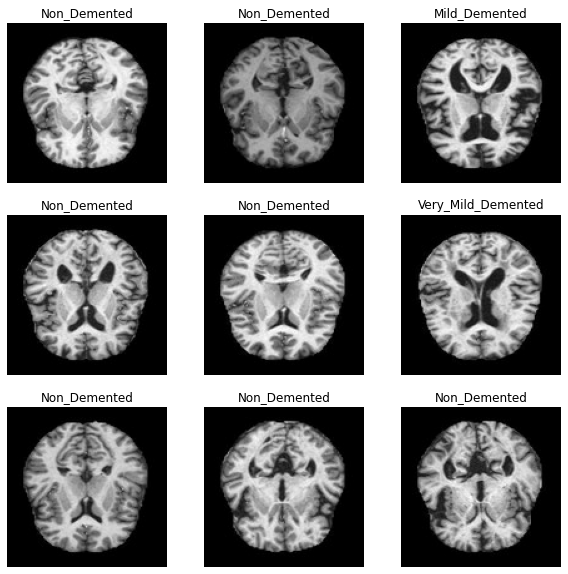

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Plot size of dataset per type

<function matplotlib.pyplot.show(close=None, block=None)>

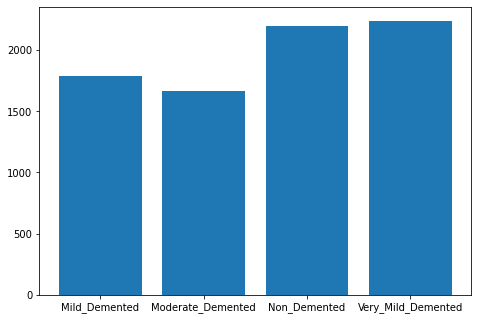

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [1785,1664,2200,2240]
ax.bar(class_names,size)
plt.show

## Prepare model

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer = "Adam",metrics=["accuracy"])
model.summary()

## Run model

In [ ]:
hist = model.fit(train_ds,validation_data=val_ds,epochs=10, batch_size=64, verbose=1)
model.save("/content/model")

Epoch 1/10
80/80 [==============================] - 110s 1s/step - loss: 1.2167 - accuracy: 0.4970 - val_loss: 0.9979 - val_accuracy: 0.5164
Epoch 2/10
80/80 [==============================] - 109s 1s/step - loss: 0.9229 - accuracy: 0.5685 - val_loss: 0.8655 - val_accuracy: 0.6291
Epoch 3/10
80/80 [==============================] - 100s 1s/step - loss: 0.8437 - accuracy: 0.6214 - val_loss: 0.7424 - val_accuracy: 0.6729
Epoch 4/10
80/80 [==============================] - 97s 1s/step - loss: 0.7559 - accuracy: 0.6706 - val_loss: 0.7074 - val_accuracy: 0.6729
Epoch 5/10
80/80 [==============================] - 98s 1s/step - loss: 0.6635 - accuracy: 0.7175 - val_loss: 0.6136 - val_accuracy: 0.7684
Epoch 6/10
80/80 [==============================] - 98s 1s/step - loss: 0.5573 - accuracy: 0.7701 - val_loss: 0.4700 - val_accuracy: 0.8263
Epoch 7/10
80/80 [==============================] - 104s 1s/step - loss: 0.4587 - accuracy: 0.8091 - val_loss: 0.5516 - val_accuracy: 0.7543
Epoch 8/10
80/80

## Get confusion matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
model = keras.models.load_model("model")
y_val = np.concatenate([y for x, y in val_ds])
x_val = np.concatenate([x for x, y in val_ds])
"""
for image_batch, labels_batch in val_ds:
  x_val = image_batch.numpy()
  y_val = labels_batch.numpy()
"""
target_names = class_names

ypred = model.predict(x_val, verbose=1)
ypred = np.argmax(ypred, axis=1)

print(classification_report(y_val, ypred, target_names=target_names))


# create confusion matrix
cm = tf.math.confusion_matrix(labels=y_val, predictions=ypred, num_classes=4)
cm = cm.numpy()
print(cm)

20/20 [==============================] - 3s 141ms/step
                    precision    recall  f1-score   support

     Mild_Demented       0.10      0.10      0.10        89
 Moderate_Demented       0.17      0.17      0.17         6
      Non_Demented       0.47      0.47      0.47       320
Very_Mild_Demented       0.31      0.30      0.30       224

          accuracy                           0.36       639
         macro avg       0.26      0.26      0.26       639
      weighted avg       0.36      0.36      0.36       639

[[  9   1  49  30]
 [  2   1   1   2]
 [ 46   1 151 122]
 [ 33   3 120  68]]


## Plot confusion matrix

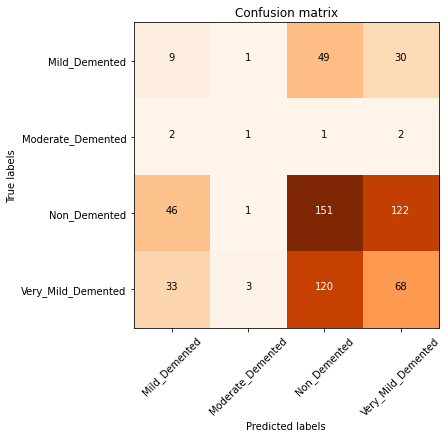

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
target_names = ('Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented')
plot_confusion_matrix(cm, target_names)

## Unzip different model if needed

In [ ]:
#to save the model make it zip 
!zip -r /content/model_withaugmentation_3.zip /content/model_withaugmentation_3

  adding: content/model_withaugmentation_3/ (stored 0%)
  adding: content/model_withaugmentation_3/assets/ (stored 0%)
  adding: content/model_withaugmentation_3/variables/ (stored 0%)
  adding: content/model_withaugmentation_3/variables/variables.index (deflated 64%)
  adding: content/model_withaugmentation_3/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/model_withaugmentation_3/saved_model.pb (deflated 89%)
  adding: content/model_withaugmentation_3/keras_metadata.pb (deflated 92%)
  adding: content/model_withaugmentation_3/fingerprint.pb (stored 0%)


In [ ]:
#download the model.zip
from google.colab import files
files.download("/content/model_withaugmentation_3.zip")

FileNotFoundError: ignored

In [ ]:
#loading the model 
model = keras.models.load_model("/content/model_withaugmentation_3")

## Get Metrics

In [ ]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

In [ ]:
epochs = range(len(get_ac))
print(epochs)

range(0, 10)


## Plot metrics

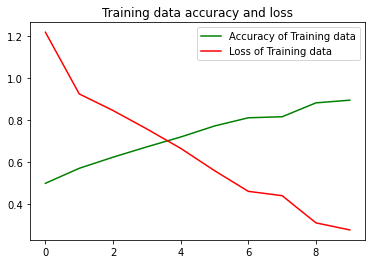

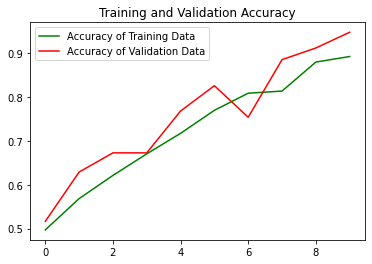

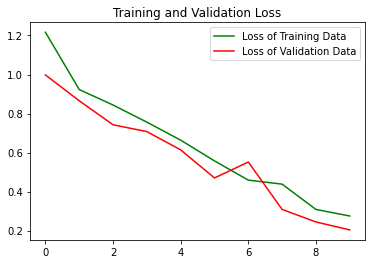

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Plot possible result

1/1 [==============================] - 0s 36ms/step


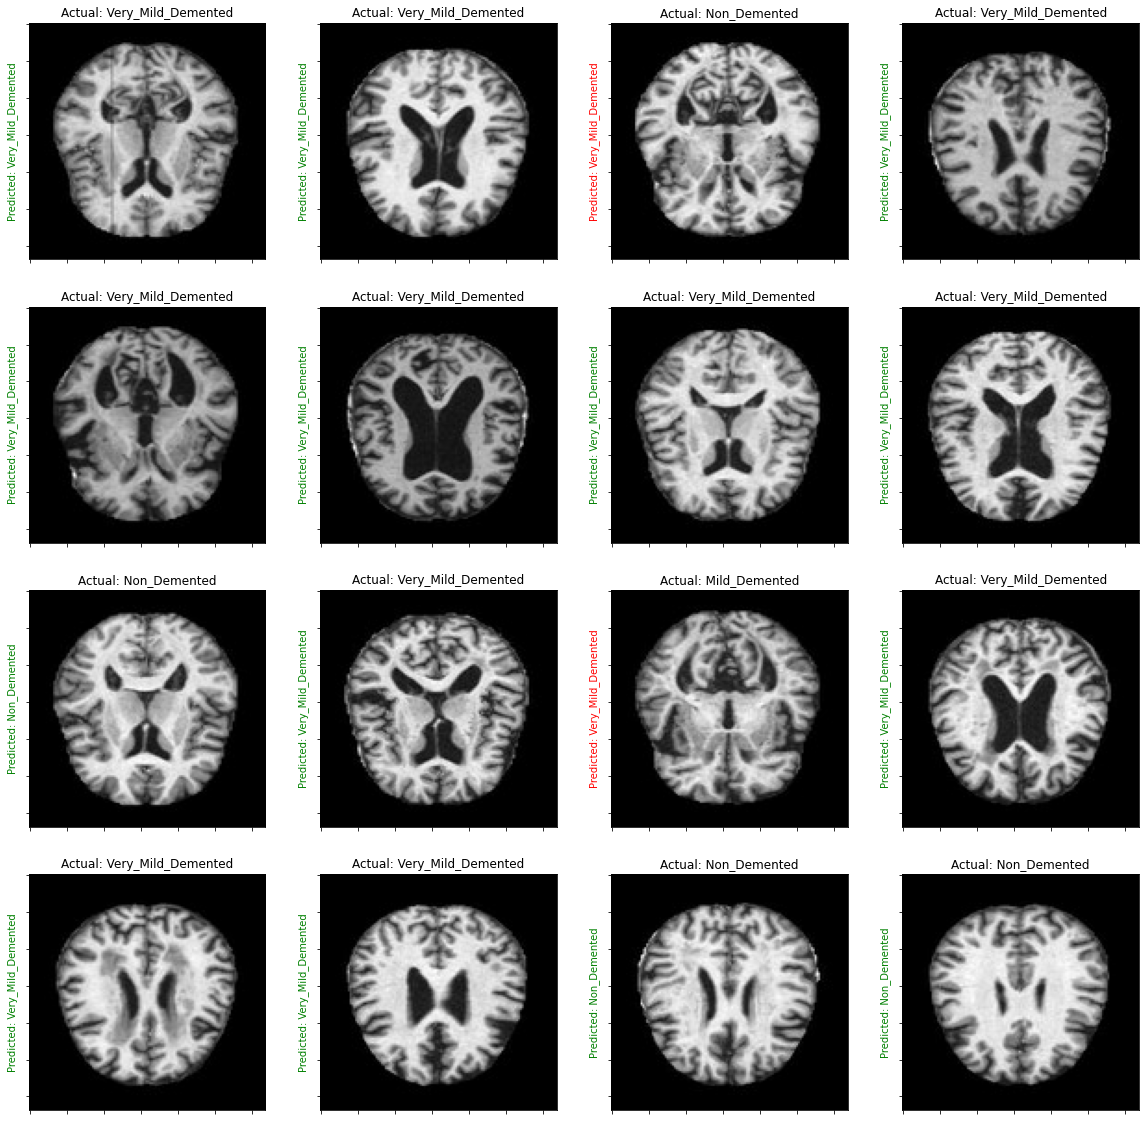

In [ ]:
loss, accuracy = model.evaluate(test_ds)
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.savefig( 'result_augu_2.png', dpi=500, bbox_inches = 'tight')

## Get Accuracy from confusion matrix

In [ ]:
#calculate accuracy of correct prediction (diagonal)
sum = 0
diagonal_sum = 0
for m in range(0, len(cm)):
  for n in range(0, len(cm[0])):
    sum = sum + cm[m][n]
    if(m==n):
      diagonal_sum = diagonal_sum + cm[m][n]
print(diagonal_sum/sum)

0.35837245696400627


## Data augmentation

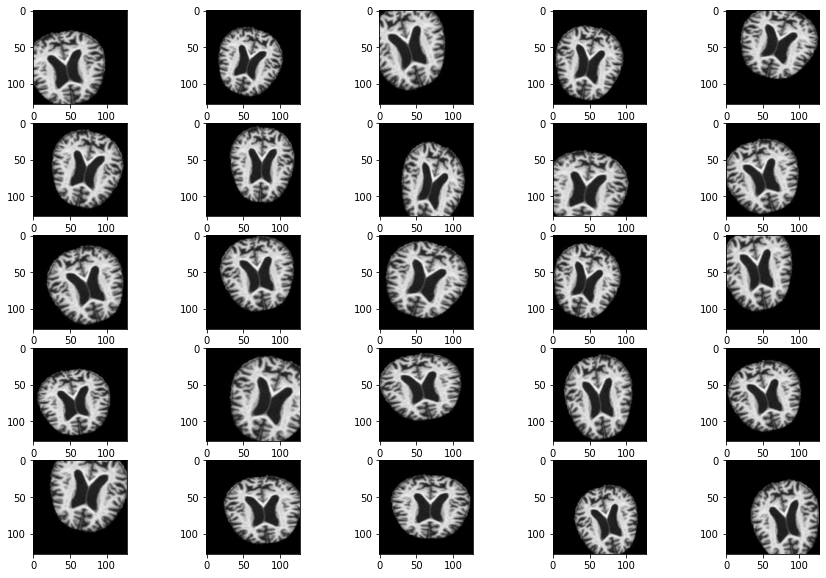

In [ ]:
#---import the modules---
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---load the image---
image_filename = '/content/dataset_withaugmentation/Dataset/Moderate_Demented/moderate.jpg'
img = load_img(image_filename)
#---convert the image to 3D array---
image_data = img_to_array(img)
#---convert into a 4-D array of 1 element of 3D array representing
# the image---
images_data = np.expand_dims(image_data, axis=0)

datagen = ImageDataGenerator(rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
train_generator = datagen.flow(images_data, batch_size=1)
rows = 5
columns = 5
fig, axes = plt.subplots(rows,columns)
for r in range(rows):
    for c in range(columns):
        image_batch = train_generator.next()
        image = image_batch[0].astype('uint8')
        axes[r,c].imshow(image)
fig.set_size_inches(15,10)

In [ ]:
from posixpath import splitext
#---import the modules---
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob
from pathlib import Path
for image_filename in glob.glob('/content/dataset_withaugmentation_3/Dataset/Moderate_Demented/*.jpg'):
  #---load the image---
  #image_filename = '/content/dataset/Dataset/Moderate_Demented/moderate.jpg'
  img = load_img(image_filename)
  #---convert the image to 3D array---
  image_data = img_to_array(img)
  #---convert into a 4-D array of 1 element of 3D array representing
  # the image---
  images_data = np.expand_dims(image_data, axis=0)

  datagen = ImageDataGenerator(width_shift_range=0.05,
                              height_shift_range=0.05,
                              horizontal_flip=False,
                              rotation_range=10,
                              brightness_range=[0.5,1.5],
                              zoom_range=[1,0.9])
  train_generator = datagen.flow(images_data, batch_size=1)
  rows = 5
  columns = 5
  #fig, axes = plt.subplots(rows,columns)
  for r in range(rows):
      for c in range(columns):
          image_batch = train_generator.next()
          image = image_batch[0].astype('uint8')
          #axes[r,c].imshow(image)
          im = Image.fromarray(image)
          image_filename_noextension = Path(image_filename).stem
          im.save("/content/dataset_withaugmentation_3/Dataset/Moderate_Demented/"+image_filename_noextension+str(r)+str(c)+".jpg")
  #fig.set_size_inches(15,10)

In [ ]:
#EXTREAM VERSION
from posixpath import splitext
#---import the modules---
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob
from pathlib import Path
for image_filename in glob.glob('/content/dataset/Dataset/Mild_Demented/*.jpg'):
  #---load the image---
  #image_filename = '/content/dataset/Dataset/Moderate_Demented/moderate.jpg'
  img = load_img(image_filename)
  #---convert the image to 3D array---
  image_data = img_to_array(img)
  #---convert into a 4-D array of 1 element of 3D array representing
  # the image---
  images_data = np.expand_dims(image_data, axis=0)

  datagen = ImageDataGenerator(rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
  train_generator = datagen.flow(images_data, batch_size=1)
  rows = 1
  columns = 1
  #fig, axes = plt.subplots(rows,columns)
  for r in range(rows):
      for c in range(columns):
          image_batch = train_generator.next()
          image = image_batch[0].astype('uint8')
          #axes[r,c].imshow(image)
          im = Image.fromarray(image)
          image_filename_noextension = Path(image_filename).stem
          im.save("/content/dataset/Dataset/Mild_Demented/"+image_filename_noextension+str(r)+str(c)+".jpg")
  #fig.set_size_inches(15,10)

KeyboardInterrupt: ignored

# SVM



In [ ]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
Categories=['Mild_Demented','Moderate_Demented','Non_Demented','Very_Mild_Demented']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir='/content/dataset/Dataset' 
#path which contains all the categories of images
for i in Categories:
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(128,128,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target
x=df.iloc[:,:-1] #input data 
y=df.iloc[:,-1] #output data
df
print(x)
print(y)

loading... category : Mild_Demented
loaded category:Mild_Demented successfully
loading... category : Moderate_Demented
loaded category:Moderate_Demented successfully
loading... category : Non_Demented
loaded category:Non_Demented successfully
loading... category : Very_Mild_Demented
loaded category:Very_Mild_Demented successfully
      0      1      2      3      4      5      6      7      8      9      \
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
6395    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6396    0.0    0.0    0.0    0.0    0.0    0

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y)


In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='linear',gamma='auto',probability=True)
svc.fit(x_train, y_train)

In [ ]:
y2 = svc.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test,y2))

Accuracy on unknown data is 0.979375


In [ ]:
from sklearn.metrics import classification_report
print("Accuracy on unknown data is",classification_report(y_test,y2))

Accuracy on unknown data is               precision    recall  f1-score   support

           0       0.98      0.97      0.97       216
           1       1.00      0.85      0.92        20
           2       0.98      0.99      0.99       795
           3       0.98      0.97      0.97       569

    accuracy                           0.98      1600
   macro avg       0.98      0.95      0.96      1600
weighted avg       0.98      0.98      0.98      1600



In [ ]:
result = pd.DataFrame({'original' : y_test,'predicted' : y2})

In [ ]:
# create confusion matrix
cm = tf.math.confusion_matrix(labels=y_test, predictions=y2, num_classes=4)
cm = cm.numpy()
print(cm)

[[210   0   2   4]
 [  1  17   0   2]
 [  0   0 788   7]
 [  4   0  13 552]]


In [ ]:
print("The predicted Data is :")
print(y2)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(y2,y_test)*100}% accurate")

The predicted Data is :
[2 2 2 ... 2 3 2]
The actual data is:
[2 2 2 ... 2 3 2]
The model is 97.9375% accurate


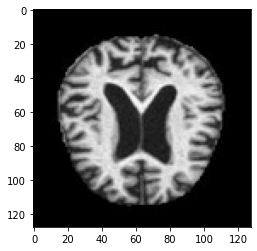

OSError: ignored

In [ ]:
from tensorflow.keras.utils import load_img
image_filename = '/content/dataset/Dataset/Moderate_Demented/moderate.jpg'
img = load_img(image_filename)
plt.imshow(img)
plt.show()
img_array=imread(img)
img_resize=resize(img_array,(128,128,3))
l=[img_resize.flatten()]
probability=model.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[model.predict(l)[0]])

Enter URL of Image :https://upload.wikimedia.org/wikipedia/commons/b/b2/MRI_of_Human_Brain.jpg


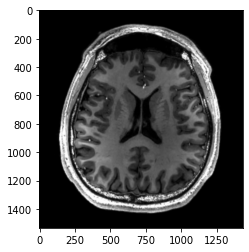

AttributeError: ignored

In [ ]:
url=input('Enter URL of Image :')
img=imread(url)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=svc.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[svc.predict(l)[0]])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
target_names = ('Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented')
plot_confusion_matrix(cm, target_names)

In [ ]:
result

,original,predicted
3679,2,2
3089,2,2
3988,2,2
4428,3,3
3357,2,2
...,...,...
5909,3,3
5094,3,3
684,0,0
3146,2,2
